# Introduction to GANs

"GANs" is the most exciting idea in the last 10 years in machine learning - Yann LeCun

Applications of GANs:
- Combining images
- SRGAN --> Increasing resolution
- Transform images across domains
- Data Augmentation
- Medical Applications
- Semi-supervised learning(SRGAN)

What are GANS:
A class of machine learning techniques that consists of two networks playing an adversarial game against each other. <br>


GANs consist of two networks:
1. Generator - trying to fool the dicriminator by generating images close to real images
2. Discriminator - trying to indentify the fake images

In the end the Generator generates images that are indistinguishable from real images and the discriminator is forced to guess with probability =1/2 <br> <br>
**Note**: Both the Generator and Discriminator actually start from scratch meaning they are both randomly initialized at start and then simulataneously trained.

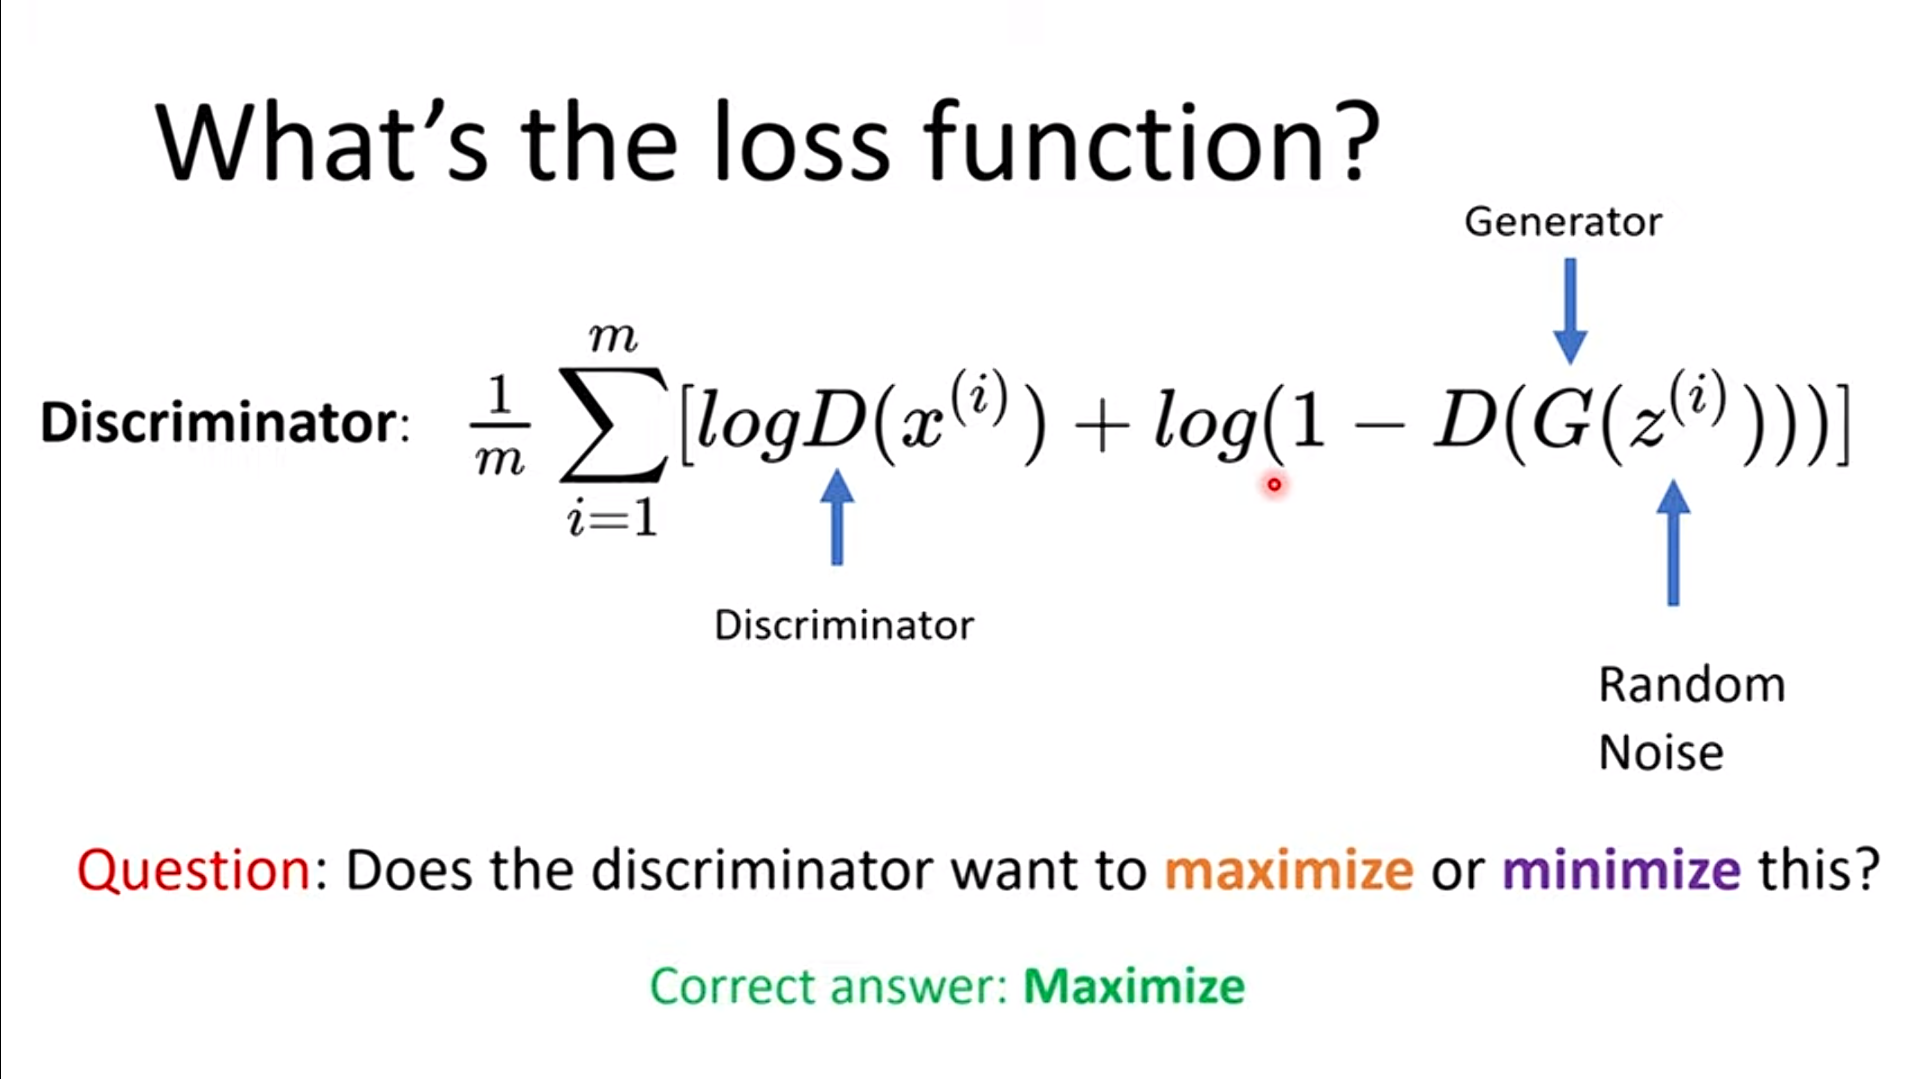

# Building a simple GAN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
# setting the hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28*28*1
batch_size = 1000
num_epochs = 50

In [5]:
disc = Discriminator(image_dim).to(device)

gen = Generator(z_dim, image_dim).to(device)

fixed_noise = torch.randn((batch_size, z_dim)).to(device)

transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [6]:
dataset = datasets.MNIST(root='dataset/', transform=transforms, download=True)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)

opt_gen = optim.Adam(gen.parameters(), lr=lr)

criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # train Discriminator: max log(D(real)) + log(1- D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_fake + lossD_real) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # train Generator: min log(1 - D(G(z))) <--> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                writer_fake.add_image("Generated", img_grid_fake, global_step=step)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                step += 1

Epoch [0/50] Batch 0/60                   Loss D: 0.6715, loss G: 0.6567
Epoch [1/50] Batch 0/60                   Loss D: 0.7746, loss G: 0.5865
Epoch [2/50] Batch 0/60                   Loss D: 0.5054, loss G: 0.9408
Epoch [3/50] Batch 0/60                   Loss D: 0.1453, loss G: 2.1675
Epoch [4/50] Batch 0/60                   Loss D: 0.1685, loss G: 2.0375
Epoch [5/50] Batch 0/60                   Loss D: 0.2073, loss G: 1.4621
Epoch [6/50] Batch 0/60                   Loss D: 0.3776, loss G: 0.9823
Epoch [7/50] Batch 0/60                   Loss D: 0.6709, loss G: 0.5862
Epoch [8/50] Batch 0/60                   Loss D: 0.5622, loss G: 0.7251
Epoch [9/50] Batch 0/60                   Loss D: 0.4801, loss G: 0.8891
Epoch [10/50] Batch 0/60                   Loss D: 0.3942, loss G: 1.0097
Epoch [11/50] Batch 0/60                   Loss D: 0.3377, loss G: 1.2596
Epoch [12/50] Batch 0/60                   Loss D: 0.4491, loss G: 0.8672
Epoch [13/50] Batch 0/60                   Loss 

# Things to try:
1. what happens if we use a larger network
2. better normalization with batchnorm
3. different learning rate
4. change architecture to CNN

# Increasing Complexity of the model

In [22]:
torch.cuda.is_available()

True

### 1. Updated Discriminator

In [15]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


### 2. Updated Generator

In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [17]:
# setting the hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28*28*1  # for MNIST
batch_size = 32
num_epochs = 50

In [18]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [19]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='dataset/', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

In [21]:
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

In [ ]:
step = 0
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, image_dim).to(device)
        batch_size = real.shape[0]

        # Train Discriminator: max log(D(real)) + log(1- D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake).view(-1)

        real_labels = 0.9 * torch.ones_like(disc_real)
        fake_labels = torch.zeros_like(disc_fake)
        lossD_real = criterion(disc_real, real_labels)
        lossD_fake = criterion(disc_fake, fake_labels)
        lossD = (lossD_fake + lossD_real) / 2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <--> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(real.reshape(-1, 1, 28, 28), normalize=True)
                writer_fake.add_image("Generated", img_grid_fake, global_step=step)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                step += 1

writer_fake.close()
writer_real.close()